In [21]:
"""
Token到Patch位置映射工具
用于分析LLaVA-Next中每个image token对应原始图像中的具体位置
"""

import os
os.environ["HF_HOME"] = "/DATA2/HuggingFace"
import os.path as osp
from typing import Tuple, List, Dict, Optional
from PIL import Image, ImageDraw
from enum import Enum
import math
from transformers import LlavaNextProcessor
from dataclasses import dataclass

class TokenType(Enum):
    BASE_IMAGE_FEATURES = 0
    HIGH_RESOLUTION_FEATURES = 1
    NEWLINE = 2

@dataclass
class TokenPosition:
    """Token位置信息"""
    token_idx: int # token index in the sequence
    block_id: int  # which block the token belongs to（0: base_image_features; 1,2,...: image_features and image_newline）
    patch_bbox: Tuple[int, int, int, int]  # bounding box of the patch in the original image (x1, y1, x2, y2)
    patch_row: int  # row index of the patch
    patch_col: int  # column index of the patch
    token_type: TokenType

class Token2PatchMapper:
    """Token到patch位置的映射器"""
    def __init__(self, model_name: str = "llava-hf/llava-v1.6-mistral-7b-hf"):
        self.processor = LlavaNextProcessor.from_pretrained(model_name)
        self.image_processor = self.processor.image_processor
        self.patch_size = getattr(self.processor, 'patch_size', 14)
        size = getattr(self.image_processor, 'size', {'shortest_edge': 336})
        self.block_size = ((size["shortest_edge"], size["shortest_edge"]) if "shortest_edge" in size else (min(size["height"], size["width"]), min(size["height"], size["width"])))
        self.image_grid_pinpoints = getattr(self.image_processor, 'image_grid_pinpoints', [[336, 672], [672, 336], [672, 672], [1008, 336], [336, 1008]])
        self.vision_feature_select_strategy = getattr(self.processor, 'vision_feature_select_strategy', 'default')

    def select_best_resolution(self, original_size: tuple, possible_resolutions: list) -> tuple:
        """选择最佳分辨率"""
        original_height, original_width = original_size
        best_fit = None
        max_effective_resolution = 0
        min_wasted_resolution = float("inf")
        for height, width in possible_resolutions:
            scale = min(width / original_width, height / original_height)
            downscaled_width, downscaled_height = int(original_width * scale), int(original_height * scale)
            effective_resolution = min(downscaled_width * downscaled_height, original_width * original_height)
            wasted_resolution = (width * height) - effective_resolution
            if effective_resolution > max_effective_resolution or (effective_resolution == max_effective_resolution and wasted_resolution < min_wasted_resolution):
                max_effective_resolution = effective_resolution
                min_wasted_resolution = wasted_resolution
                best_fit = (height, width)
        return best_fit

    def get_resized_shape_with_aspect_ratio(self, image_size: tuple, target_resolution: tuple) -> tuple:
        """在给定目标尺寸内，计算保持比例resize后的尺寸"""
        original_height, original_width = image_size
        target_height, target_width = target_resolution
        scale_w = target_width / original_width
        scale_h = target_height / original_height
        if scale_w < scale_h:
            new_width = target_width
            new_height = min(math.ceil(original_height * scale_w), target_height)
        else:
            new_height = target_height
            new_width = min(math.ceil(original_width * scale_h), target_width)
        return new_height, new_width

    def get_padding_size(self, original_resolution: tuple, target_resolution: tuple) -> tuple:
        """计算padding大小"""
        original_height, original_width = original_resolution
        target_height, target_width = target_resolution
        paste_x, r_x = divmod(target_width - original_width, 2)
        paste_y, r_y = divmod(target_height - original_height, 2)
        return (paste_y, paste_y + r_y), (paste_x, paste_x + r_x)

    def get_image_grid_shape(self, image_size: tuple, patch_size: int) -> tuple:
        """获取anyres图像的网格形状"""
        height, width = image_size
        return height // patch_size, width // patch_size

    def get_best_resolution_grid_shape(self, image_size: tuple, patch_size: int) -> tuple:
        """获取最佳分辨率的网格形状"""
        best_resolution = self.select_best_resolution(image_size, self.image_grid_pinpoints)
        return self.get_image_grid_shape(best_resolution, patch_size)

    def unpad_coordinates(self, image_size: tuple, target_resolution: tuple) -> tuple:
        """计算unpad后的有效区域坐标"""
        resized_size = self.get_resized_shape_with_aspect_ratio(image_size, target_resolution)
        padding = self.get_padding_size(resized_size, target_resolution)
        # 有效区域的坐标
        top_pad, bottom_pad = padding[0]
        left_pad, right_pad = padding[1]
        effective_height = target_resolution[0] - top_pad - bottom_pad
        effective_width = target_resolution[1] - left_pad - right_pad
        return (top_pad, left_pad, top_pad + effective_height, left_pad + effective_width)
    
    def unpad_image_get_valid_region(self, image_size: tuple, target_resolution: tuple) -> tuple:
        """
        计算unpad后的有效区域在target_resolution坐标系中的位置
        返回: (top, left, bottom, right) 在target_resolution坐标系中
        """
        original_height, original_width = image_size
        current_height, current_width = target_resolution
        
        original_aspect_ratio = original_width / original_height
        current_aspect_ratio = current_width / current_height
        
        if original_aspect_ratio > current_aspect_ratio:
            # 原图更宽，需要在高度方向unpad
            scale_factor = current_width / original_width
            new_height = int(round(original_height * scale_factor, 7))
            padding = (current_height - new_height) // 2
            return padding, 0, current_height - padding, current_width
        else:
            # 原图更高或相等，需要在宽度方向unpad
            scale_factor = current_height / original_height
            new_width = int(round(original_width * scale_factor, 7))
            padding = (current_width - new_width) // 2
            return 0, padding, current_height, current_width - padding
    
    def unpad_image_info(self, original_size: tuple, current_size: tuple) -> dict:
        """
        计算unpad操作的详细信息
        返回: 有效区域的起始和结束位置（在current_size坐标系中）
        """
        original_height, original_width = original_size
        current_height, current_width = current_size
        
        original_aspect_ratio = original_width / original_height
        current_aspect_ratio = current_width / current_height
        
        if original_aspect_ratio > current_aspect_ratio:
            # 原图更宽，高度方向需要unpad
            scale_factor = current_width / original_width
            new_height = int(round(original_height * scale_factor, 7))
            padding = (current_height - new_height) // 2
            return {
                'top': padding,
                'left': 0,
                'bottom': current_height - padding,
                'right': current_width,
                'effective_height': new_height,
                'effective_width': current_width
            }
        else:
            # 原图更高或相等，宽度方向需要unpad
            scale_factor = current_height / original_height
            new_width = int(round(original_width * scale_factor, 7))
            padding = (current_width - new_width) // 2
            return {
                'top': 0,
                'left': padding,
                'bottom': current_height,
                'right': current_width - padding,
                'effective_height': current_height,
                'effective_width': new_width
            }
    
    def map_tokens_to_patches(self, original_size: tuple) -> List[TokenPosition]:
        """将tokens映射到原始图像的patch位置"""
        original_height, original_width = original_size
        positions = []
        token_idx = 0 if self.vision_feature_select_strategy == "default" else 1
        # ============ 1. Base image features ============
        num_patches_height_base = self.block_size[0] // self.patch_size
        num_patches_width_base = self.block_size[1] // self.patch_size
        base_num_patches = num_patches_height_base * num_patches_width_base
        print(f"Base image grid: {num_patches_height_base}x{num_patches_width_base} = {base_num_patches} patches")
        for patch_id in range(base_num_patches):
            row = patch_id // num_patches_width_base
            col = patch_id % num_patches_width_base
            # 计算在原图中的坐标
            patch_h = original_height / num_patches_height_base
            patch_w = original_width / num_patches_width_base
            x1 = int(col * patch_w)
            y1 = int(row * patch_h)
            x2 = int((col + 1) * patch_w)
            y2 = int((row + 1) * patch_h)
            positions.append(TokenPosition(
                token_idx=token_idx,
                block_id=0,
                patch_bbox=(x1, y1, x2, y2),
                patch_row=row,
                patch_col=col,
                token_type=TokenType.BASE_IMAGE_FEATURES
            ))
            token_idx += 1
        print(f"Base image patches: {len(positions)}")

        # ============ 2. High resolution patches ============
        best_resolution = self.select_best_resolution(original_size, self.image_grid_pinpoints)
        print(f"Best resolution: {best_resolution[0]}x{best_resolution[1]} (HxW)")

        # 计算网格形状（有多少个block）
        num_patch_height = best_resolution[0] // self.block_size[0]
        num_patch_width = best_resolution[1] // self.block_size[1]
        print(f"High-res grid: {num_patch_height}x{num_patch_width} blocks")
        
        # 每个block内的patch数量
        patches_per_block_h = self.block_size[0] // self.patch_size
        patches_per_block_w = self.block_size[1] // self.patch_size
        print(f"Patches per block: {patches_per_block_h}x{patches_per_block_w}")
        
        # 完整网格的patch数量（unpad之前）
        total_patches_h = num_patch_height * patches_per_block_h
        total_patches_w = num_patch_width * patches_per_block_w
        print(f"Total patch grid before unpad: {total_patches_h}x{total_patches_w}")
        
        # 计算unpad信息
        unpad_info = self.unpad_image_info(
            original_size, 
            (total_patches_h * self.patch_size, total_patches_w * self.patch_size)
        )
        
        # 有效区域的patch范围
        valid_patch_top = unpad_info['top'] // self.patch_size
        valid_patch_left = unpad_info['left'] // self.patch_size
        valid_patch_bottom = unpad_info['bottom'] // self.patch_size
        valid_patch_right = unpad_info['right'] // self.patch_size
        
        effective_patches_h = valid_patch_bottom - valid_patch_top
        effective_patches_w = valid_patch_right - valid_patch_left
        
        print(f"Valid patch range after unpad:")
        print(f"  Rows: [{valid_patch_top}, {valid_patch_bottom}) = {effective_patches_h} patches")
        print(f"  Cols: [{valid_patch_left}, {valid_patch_right}) = {effective_patches_w} patches")
        
        # 计算从处理后的坐标到原图坐标的映射
        # 关键：unpad后的有效区域对应原图的完整尺寸
        effective_pixel_h = unpad_info['effective_height']
        effective_pixel_w = unpad_info['effective_width']
        
        # 每个patch在原图中的实际大小
        patch_height_in_original = original_height / effective_patches_h
        patch_width_in_original = original_width / effective_patches_w
        
        print(f"Each patch in original image: {patch_height_in_original:.2f}x{patch_width_in_original:.2f} pixels")
        
        # 遍历有效区域内的所有patches
        for row_idx in range(effective_patches_h):
            for col_idx in range(effective_patches_w):
                # 在原图中的位置
                y1 = int(row_idx * patch_height_in_original)
                y2 = int((row_idx + 1) * patch_height_in_original)
                x1 = int(col_idx * patch_width_in_original)
                x2 = int((col_idx + 1) * patch_width_in_original)
                
                # 确保不超出边界
                x1 = max(0, min(x1, original_width))
                y1 = max(0, min(y1, original_height))
                x2 = max(0, min(x2, original_width))
                y2 = max(0, min(y2, original_height))
                
                positions.append(TokenPosition(
                    token_idx=token_idx,
                    block_id=1,
                    patch_bbox=(x1, y1, x2, y2),
                    patch_row=row_idx,
                    patch_col=col_idx,
                    token_type=TokenType.HIGH_RESOLUTION_FEATURES
                ))
                token_idx += 1
            
            # 每行末尾添加newline token
            positions.append(TokenPosition(
                token_idx=token_idx,
                block_id=1,
                patch_bbox=(-1, -1, -1, -1),
                patch_row=row_idx,
                patch_col=-1,
                token_type=TokenType.NEWLINE
            ))
            token_idx += 1
        return positions

In [22]:
from deephallu.data.mme import MMEDataset
dataset = MMEDataset()
image, _, image_name, _, question, _ = dataset[0]
print(f"分析图像: {image_name} (尺寸: {image.size})")
mapper = Token2PatchMapper()
positions = mapper.map_tokens_to_patches((image.size[1], image.size[0]))

分析图像: 21580 (尺寸: (1100, 808))


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11140.25it/s]

Base image grid: 24x24 = 576 patches
Base image patches: 576
Best resolution: 672x672 (HxW)
High-res grid: 2x2 blocks
Patches per block: 24x24
Total patch grid before unpad: 48x48
Valid patch range after unpad:
  Rows: [6, 41) = 35 patches
  Cols: [0, 48) = 48 patches
Each patch in original image: 23.09x22.92 pixels


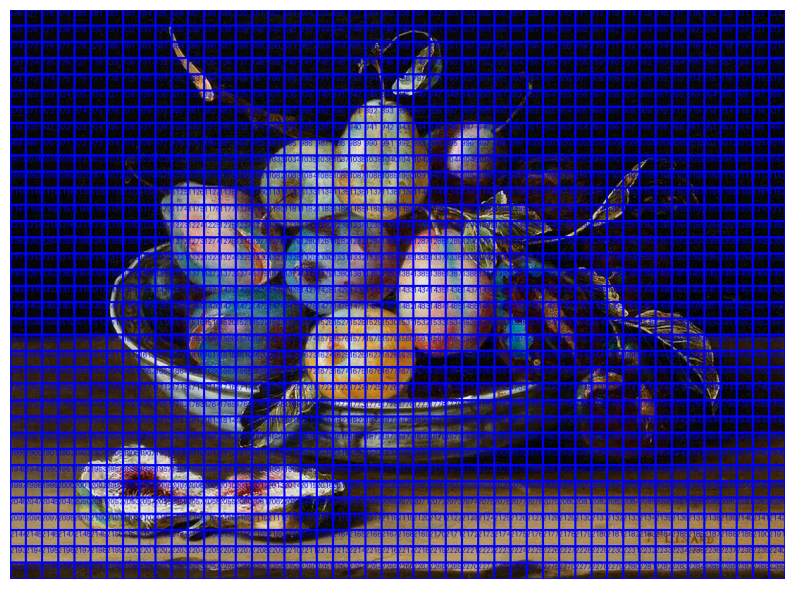

In [23]:
import matplotlib.pyplot as plt
vis_image = image.copy()
draw = ImageDraw.Draw(vis_image)
# 不同颜色表示不同的block
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
for pos in positions:
    if pos.token_type == TokenType.HIGH_RESOLUTION_FEATURES:  # 跳过newline tokens
        color = colors[pos.block_id % len(colors)]
        x1, y1, x2, y2 = pos.patch_bbox
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        # 添加token索引标签
        draw.text((x1, y1), str(pos.token_idx), fill=color)
plt.figure(figsize=(10, 10))
plt.imshow(vis_image)
plt.axis('off')
plt.show()

In [24]:
high_res_positions = [pos for pos in positions if pos.token_type == TokenType.HIGH_RESOLUTION_FEATURES]
print(len(high_res_positions))
print(high_res_positions[0])
print(high_res_positions[-1])


1680
TokenPosition(token_idx=576, block_id=1, patch_bbox=(0, 0, 22, 23), patch_row=0, patch_col=0, token_type=<TokenType.HIGH_RESOLUTION_FEATURES: 1>)
TokenPosition(token_idx=2289, block_id=1, patch_bbox=(1077, 784, 1100, 808), patch_row=34, patch_col=47, token_type=<TokenType.HIGH_RESOLUTION_FEATURES: 1>)
